In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Base Model
$$
d \nu(t) = \kappa(\theta - \nu(t) ) dt + \xi \sqrt{\nu(t)} dW_{t}^\nu + J_t dN_t
$$

In [5]:
def download_and_prepare_data(ticker='TSLA', start_date='2020-01-01', end_date=None, window=20):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['daily_vol'] = df['log_return'].rolling(window=window).std()
    df['daily_variance'] = df['daily_vol']**2
    df['anaulized_vol'] = df['daily_vol'] * np.sqrt(252)
    df = df.dropna()
    return df

In [7]:
df = download_and_prepare_data('TSLA', '2020-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


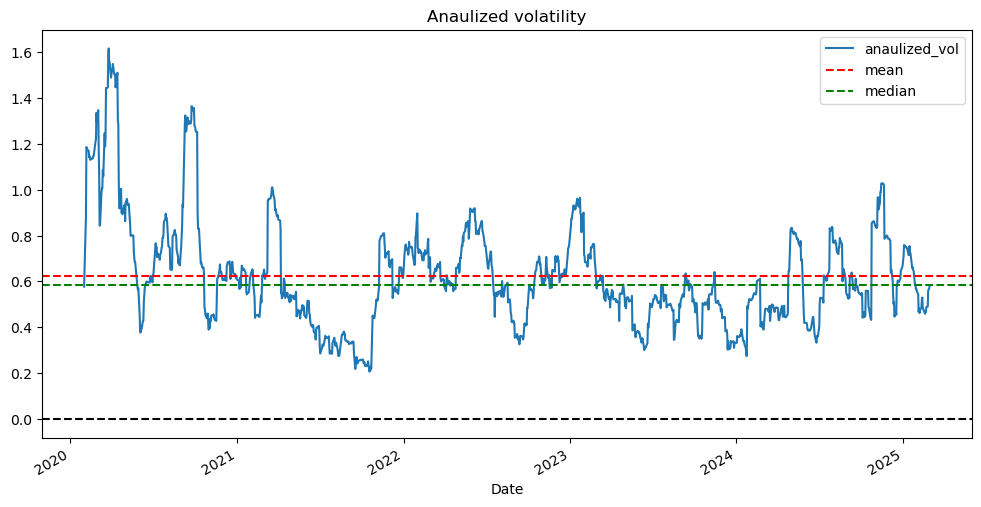

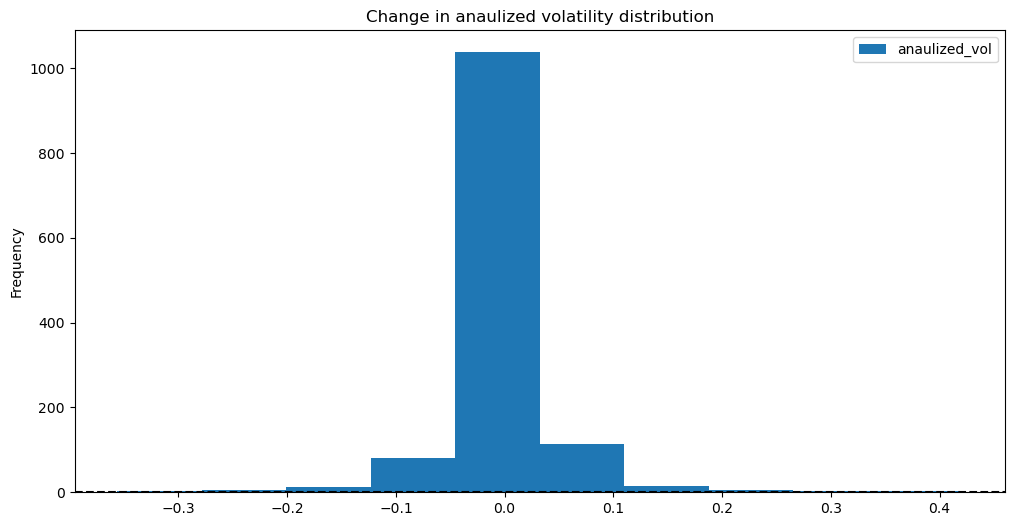

In [24]:
plt.figure(figsize = (12,6))
df['anaulized_vol'].plot(title='Anaulized volatility')
plt.axhline(y=df['anaulized_vol'].mean(),linestyle='--',color='red',label='mean')
plt.axhline(y=df['anaulized_vol'].median(),linestyle='--',color='green',label='median')
plt.legend()
plt.axhline(y=0,linestyle='--',color='black')
plt.show()

plt.figure(figsize = (12,6))
df['anaulized_vol'].diff().plot.hist(title='Change in anaulized volatility distribution')
plt.legend()
plt.axhline(y=0,linestyle='--',color='black')
plt.show()

In [20]:
def estimate_initial_parameters(variance_series):
    """Estimate initial parameters for the Heston model with jumps"""
    try:
        theta_est = variance_series.median()
        xi_est = variance_series.std() / np.sqrt(max(variance_series.mean(), 1e-10))
        autocorr = max(0.01, min(variance_series.autocorr(lag=1), 0.99))
        dt = 1/252
        kappa_est = -np.log(autocorr) / dt
        kappa_est = max(0.1, min(kappa_est, 50))
        v0_est = variance_series.iloc[0]
        
        # Define "large Jump" as changes beyond 2 standard deviations for change in variance
        variance_changes = variance_series.diff().dropna()
        threshold = 2 * variance_changes.std()
        jumps = variance_changes[abs(variance_changes) > threshold]
        
        if len(jumps) > 0:
            lambda_est = len(jumps) / len(variance_changes)
            mu_J_est = jumps.mean()
            sigma_J_est = max(jumps.std(), 1e-6)  # Ensure positive
        else:
            lambda_est = 0.01
            mu_J_est = 0.0001
            sigma_J_est = 0.0005
        
        return {
            'kappa': kappa_est,
            'theta': theta_est,
            'xi': xi_est,
            'v0': v0_est,
            'lambda': lambda_est,
            'mu_J': mu_J_est,
            'sigma_J': sigma_J_est
        }
    except Exception as e:
        print(f"Error estimating parameters: {e}")
        # Return default values if estimation fails
        return {
            'kappa': 2.0,
            'theta': 0.04,
            'xi': 0.3,
            'v0': 0.04,
            'lambda': 0.01,
            'mu_J': 0.0001,
            'sigma_J': 0.0005
        }

Using parameters:
  kappa: 5.529137
  theta: 0.001354
  xi: 0.035243
  v0: 0.001325
  lambda: 0.042320
  mu_J: -0.000003
  sigma_J: 0.001333


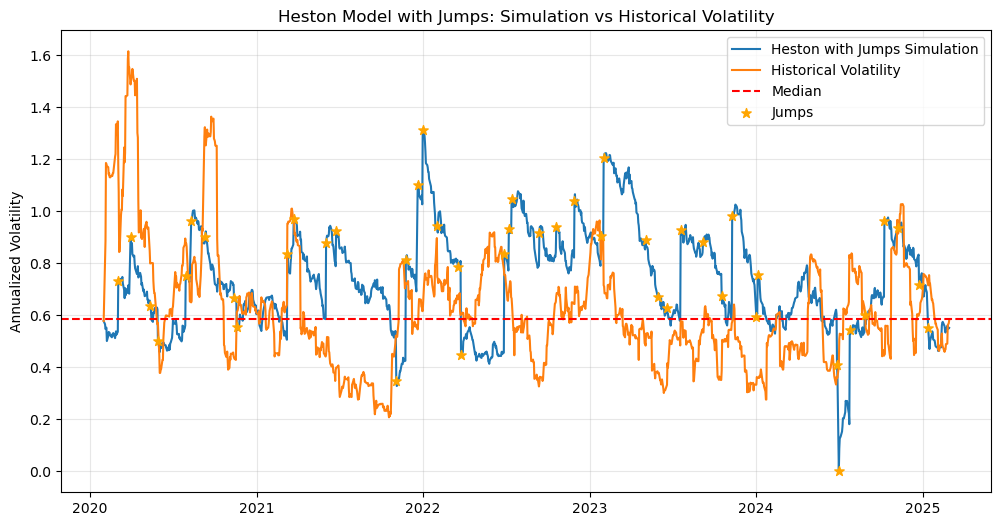

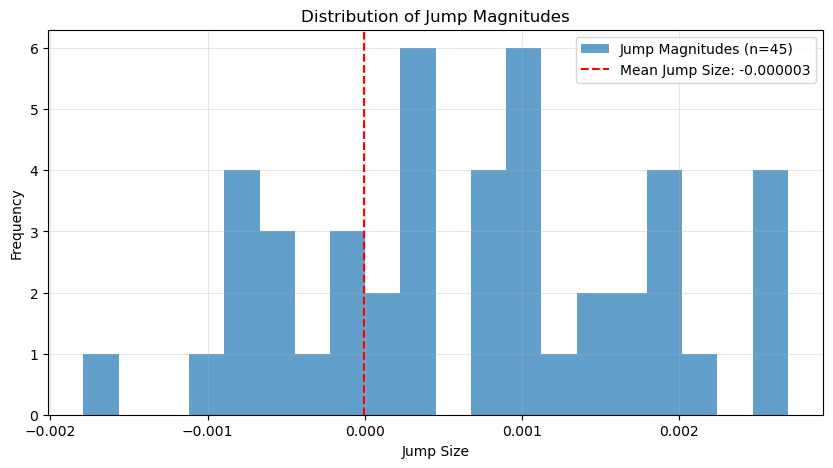

In [32]:
def OU_Jump(df, dt=1/252, plot=False):
    time_steps = len(df)
    param_estimates = estimate_initial_parameters(df['daily_variance'])
    theta = param_estimates['theta']
    kappa = param_estimates['kappa']
    xi = param_estimates['xi']
    v0 = param_estimates['v0']
    Lambda = param_estimates['lambda']
    mu_J = param_estimates['mu_J']
    sigma_J = param_estimates['sigma_J']
    
    # Print the parameters being used
    print("Using parameters:")
    for param, value in param_estimates.items():
        print(f"  {param}: {value:.6f}")
    
    # Standard normal innovations for diffusion
    Z = np.random.normal(0, 1, time_steps)
    
    # Generate jumps
    jump_occurs = np.random.binomial(1, Lambda, time_steps)
    jump_magnitude = np.random.normal(mu_J, sigma_J, time_steps)
    jump_effect = jump_occurs * jump_magnitude
    
    v = np.zeros(time_steps)
    v[0] = v0
    
    # Keep track of jumps for plotting
    jump_times = []
    jump_values = []
    
    for i in range(1, time_steps):
        # Euler-Maruyama discretization
        drift = kappa * (theta - v[i-1]) * dt
        diffusion = xi * np.sqrt(np.maximum(v[i-1], 1e-6)) * np.sqrt(dt) * Z[i]
        
        # Add jump component
        v_next = v[i-1] + drift + diffusion + jump_effect[i]
        v_next = np.maximum(v_next, 1e-10)
        v[i] = v_next
        
        # Record jumps for visualization
        if jump_occurs[i] == 1:
            jump_times.append(i)
            jump_values.append(v[i])
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Convert to annualized volatility
        vol_sim = np.sqrt(v) * np.sqrt(252)
        
        # Assuming the column name might be different
        vol_col = 'rolling_vol'
        if 'annualized_vol' in df.columns:
            vol_col = 'annualized_vol'
        elif 'anaulized_vol' in df.columns:  # Handle the potential typo
            vol_col = 'anaulized_vol'
        
        # Plot simulated and historical volatility
        ax.plot(df.index, vol_sim, label='Heston with Jumps Simulation')
        ax.plot(df.index, df[vol_col], label='Historical Volatility')
        ax.axhline(y=df[vol_col].median(), linestyle='--', color='red', label='Median')
        
        # Mark jumps on the plot
        if jump_times:
            jump_indices = [jump_times[i] for i in range(len(jump_times))]
            jump_dates = [df.index[idx] for idx in jump_indices]
            jump_vols = [np.sqrt(jump_values[i]) * np.sqrt(252) for i in range(len(jump_times))]
            ax.scatter(jump_dates, jump_vols, color='orange', s=50, marker='*', 
                       label='Jumps', zorder=3)
        
        ax.legend()
        ax.set_title('Heston Model with Jumps: Simulation vs Historical Volatility')
        ax.set_ylabel('Annualized Volatility')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Plot the jump distribution
        if sum(jump_occurs) > 0:
            fig, ax = plt.subplots(figsize=(10, 5))
            actual_jumps = jump_magnitude[jump_occurs == 1]
            ax.hist(actual_jumps, bins=min(20, len(actual_jumps)), alpha=0.7, 
                   label=f'Jump Magnitudes (n={len(actual_jumps)})')
            ax.axvline(x=mu_J, color='red', linestyle='--', 
                      label=f'Mean Jump Size: {mu_J:.6f}')
            ax.set_title('Distribution of Jump Magnitudes')
            ax.set_xlabel('Jump Size')
            ax.set_ylabel('Frequency')
            ax.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    
    return v

v_sim = OU_Jump(df,plot=True)